In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import grad
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import cholesky,LinAlgError
from modified_minimize import *
torch.set_default_dtype(torch.float64)
torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEFAULT_WIDTH = 20
DEFAULT_DEPTH = 4

class PINN_U(nn.Module):
    def __init__(self, width=DEFAULT_WIDTH, depth=DEFAULT_DEPTH):
        super(PINN_U, self).__init__()
        self.width = width
        if depth < 2:
          raise ValueError(f"depth must be at least 2, got {depth}")
        self.depth = depth
        self.act = nn.Tanh()

        # layer definitions
        self.FC_dict = nn.ModuleDict()
        self.FC_dict[f"layer 1"] = nn.Linear(1, self.width)
        for i in range(2, depth):
          self.FC_dict[f"layer {i}"] = nn.Linear(self.width, self.width)
        self.FC_dict[f"layer {depth}"] = nn.Linear(self.width, 1)

    def forward(self, x):
      for key, layer in self.FC_dict.items():
        x = layer(x)
        if key != f"layer {self.depth}":
          x = self.act(x)
      return x
    
model_U = PINN_U().to(device)
print(model_U)
LAMBDA_INIT = 0.5
l = torch.tensor([LAMBDA_INIT,], dtype=torch.float64, device=device, requires_grad=True)

params = list(model_U.parameters()) 

PINN_U(
  (act): Tanh()
  (FC_dict): ModuleDict(
    (layer 1): Linear(in_features=1, out_features=20, bias=True)
    (layer 2): Linear(in_features=20, out_features=20, bias=True)
    (layer 3): Linear(in_features=20, out_features=20, bias=True)
    (layer 4): Linear(in_features=20, out_features=1, bias=True)
  )
)


In [2]:
def compute_loss(model_U,l,y1,c):
    #interior and smoothness losses
    z1 = torch.sinh(y1)
    U = model_U(y1)-model_U(-y1)-z1**(1/3)*(z1/(1+z1))**15
    Uy = grad(U.sum(), y1, create_graph=True)[0]
    Fu = -l * U + ((1+l)*torch.sinh(y1)+U)/torch.cosh(y1) * Uy
    Fu_x = grad(Fu.sum(), y1, create_graph=True)[0]
    loss_i = torch.mean(Fu**2)
    loss_s = torch.mean(Fu_x**2)
    
    # define the loss on the boundary
    k= np.sinh(c)
    z = torch.tensor([c], dtype=torch.double, device=device, requires_grad=True).reshape(1,1) # (batch, 1)
    U = model_U(z)-model_U(-z)
    loss_b = torch.abs(U)**2
    loss =0.1*loss_i +1*loss_b +0.1*loss_s
    return [loss, loss_i, loss_b, loss_s]
def get_flat_params(model_U):
    return np.concatenate([p.detach().cpu().numpy().ravel() for p in model_U.parameters()])
def set_flat_params(model_U,flat_params):
    """Set model parameters from a flat NumPy array."""
    
    idx = 0
    for p in model_U.parameters():
        numel = p.numel()
        new_values = torch.from_numpy(flat_params[idx:idx+numel]).reshape(p.shape)
        p.data.copy_(new_values)
        idx += numel
def loss_and_grad(flat_params,model_U,l,y1,c):
    """Compute loss and gradients for BFGS."""
    set_flat_params(model_U,flat_params)  # Update model parameters
    model_U.zero_grad()
    if l.grad is not None:
        l.grad.zero_()
    [loss, loss_i, loss_b, loss_s]= compute_loss(model_U,l,y1,c)  # Compute loss
  
    # Compute gradients
    loss.backward()
    grads = np.concatenate([p.grad.detach().cpu().numpy().ravel() for p in model_U.parameters()])
   
    
    return loss.item(), grads  # SciPy requires (loss, gradients)
def lbfgsrun(model_U,l,c,batchsize,Nprint_bfgs,Nchange,Nbfgs):

    torch.manual_seed(0)
    np.random.seed(0)
    y1 = ( (c*torch.rand(batchsize, 1, device=device)))# (batch, 1) resample y
    y1.requires_grad=True
    
    # Initialize parameters
    init_params = get_flat_params(model_U)
   

    cont=0
    losses = np.zeros(Nbfgs//Nprint_bfgs+100)
    initial_scale=False
    def callback(*,intermediate_result): 
        nonlocal cont,losses
        if (cont+1)%Nprint_bfgs == 0 or cont == 0:
            loss_value = intermediate_result.fun
            losses[(cont+1)//Nprint_bfgs] = loss_value
            
    
            print(loss_value,cont+1)
        cont+=1
    H0 = torch.eye(len(init_params))
    H0 = H0.numpy()
    options={'maxiter':Nchange, 'gtol': 0, "hess_inv0":H0,
        "method_bfgs":"SSBroyden1", "initial_scale":initial_scale}
    
    while cont < Nbfgs: #Training loop
        result = minimize(loss_and_grad,init_params,args = (model_U, l,y1,c),
              method="BFGS",jac=True, options=options,
              tol=0,callback=callback) 
        init_params = result.x
    
        H0 = result.hess_inv
        H0 = (H0 + np.transpose(H0))/2
        try:
            cholesky(H0)
        except LinAlgError:
            H0 = torch.eye(len(init_params))
            H0 = H0.numpy()
    
        options={'maxiter':Nchange, 'gtol': 0, "hess_inv0":H0,
        "method_bfgs":"SSBroyden1", "initial_scale":initial_scale}
        y1 = ( (c*torch.rand(batchsize, 1, device=device)))# (batch, 1) resample y
        y1.requires_grad=True
    return losses

In [27]:
losses = lbfgsrun(model_U, l,c=30,batchsize=10000,Nprint_bfgs=100,Nchange=1000,Nbfgs=20000)

0.17432310824291544 1
7.599747142407398e-08 100
3.505878550247812e-11 200
3.958170247136233e-12 300
5.755040346053223e-13 400
2.9238123570558304e-13 500
2.3284133452342975e-13 600
2.1322998422023643e-13 700
1.9705883185748346e-13 800
1.749357284429537e-13 900
1.488796913134596e-13 1000
1.209612992598429e-13 1100
8.191842339625331e-14 1200
5.5851385827725753e-14 1300
4.120464988207167e-14 1400
2.866289400063386e-14 1500
1.6504453923940807e-14 1600
1.3713385375790192e-14 1700
8.437616032142806e-15 1800
4.901447381491106e-15 1900
2.4292831873827734e-15 2000
2.4131612074957142e-15 2100
1.8983290224419525e-15 2200
1.2841894566139875e-15 2300
9.92845085549616e-16 2400
5.949513762632006e-16 2500
3.151619038953478e-16 2600
2.1116000085782612e-16 2700
1.2739213184506706e-16 2800
1.0013711767448901e-16 2900
6.091439674942194e-17 3000
5.836270903030114e-17 3100
5.559561281819965e-17 3200
4.778001665609641e-17 3300
4.186272974983785e-17 3400
3.4388282806396753e-17 3500
2.352578591199925e-17 3600
1

/central/home/roywang/PINN/modified_optimize.py:1633: RuntimeWarning: invalid value encountered in sqrt
  rhokm = min(1,hk*(1-np.sqrt(np.abs(ak)/(1+ak))))
/central/home/roywang/PINN/modified_optimize.py:1635: RuntimeWarning: invalid value encountered in sqrt
  thetakp = max(1,bk*(1+np.sqrt(np.abs(ak)/(1+ak))))


6.340561657779653e-20 19700
6.220875000394916e-20 19800
6.164922958417579e-20 19900
6.079484094656029e-20 20000


tensor([0.5000], device='cuda:0', requires_grad=True)


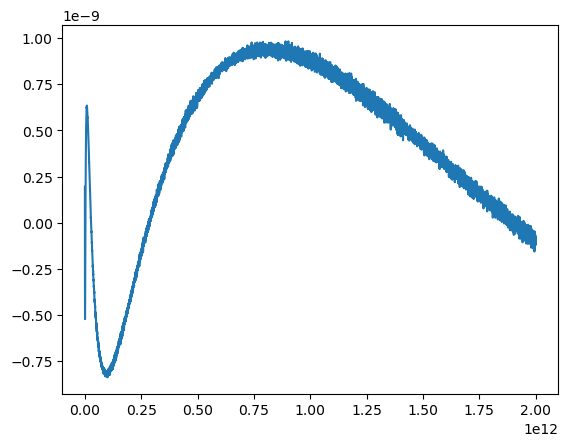

In [28]:
y = torch.linspace(2000000000000,0,10001, requires_grad=True).to(device).reshape(10001,1)
z =  torch.arcsinh(y)    
U = model_U(z)-model_U(-z)-y**(1/3)*(y/(1+y))**15
print(l)


Uy = grad(U.sum(), y, create_graph=True)[0]
#interior and smoothness losses
Fu = -l * U + ((1+l)*y + U) * Uy


fig = plt.figure()
plt.plot(y.detach().cpu().numpy(), Fu.detach().cpu().numpy())
plt.show()


In [29]:
torch.save(model_U.state_dict(), f"model_U_10000batch_20000its_exact.pth")

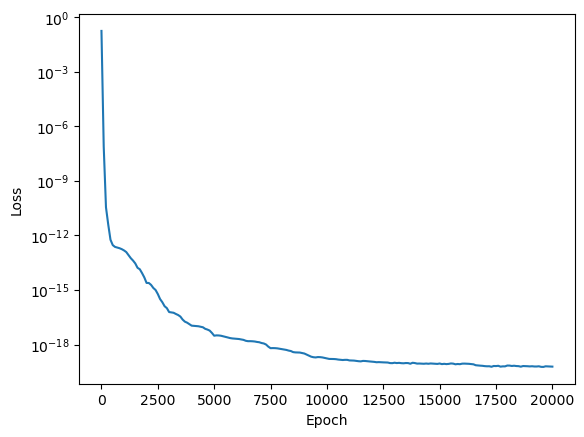

In [30]:
fig = plt.figure()
plt.xlabel('Epoch') 
plt.ylabel('Loss')
x=[i*100 for i in range(201)]
plt.semilogy(x,losses[:201])
plt.show()